In [2]:
from os.path import isdir, join
import pickle
import numpy as np
import matplotlib.pyplot as plt
# import rosbag
import glob
from sklearn.model_selection import train_test_split, KFold
import os
import pdb
import math
import torch
from os.path import join
from mpl_toolkits.mplot3d import Axes3D

In [3]:
dataset_filename = "multi_intention_dataset_fast.p"
dataset_filepath = join('Dataset', dataset_filename)
with open(dataset_filepath,'rb') as f:
    u = pickle._Unpickler( f )
    u.encoding = 'latin1'
    raw_data = u.load()
    


In [4]:
data = {}
for intention, traj in zip(raw_data['intentions'], raw_data['trajs']):
    if intention not in data.keys():
        data[intention] = []
    traj = torch.from_numpy(traj).float()*100.
    data[intention].append(traj)

In [5]:
data[1] = data[2]

In [6]:
data.keys()

dict_keys([2, 0, 1])

/home/hcalab/Desktop/MYJ/FIT/HumanIntention/myenv/lib/python3.6/site-packages/mpl_toolkits/mplot3d/proj3d.py:189: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array([xs, ys, zs, np.ones_like(xs)])


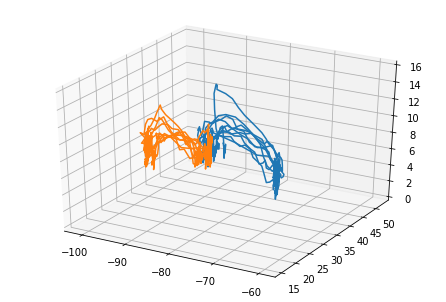

In [7]:
%matplotlib inline
fig = plt.figure()
ax = Axes3D(fig)
# ax.axis('equal')
for intention in [0,1]:
    color_traj = 'C'+str(intention)
    for traj in data[intention]:
        ax.plot(traj[:,0],traj[:,1],traj[:,2], c=color_traj)
plt.show()

In [8]:
xtrain, xtest, ytrain, ytest = [], [], [], []
for intention in [0, 1]:
    intention_label = [intention for i in range(len(data[intention]))]
    xtraini, xtesti, ytraini, ytesti = train_test_split(data[intention], intention_label, test_size=5, random_state=0)
    xtrain += xtraini
    ytrain += ytraini
    xtest += xtesti
    ytest += ytesti

In [9]:
from scipy.interpolate import interp1d as interp
def process_data(raw_x, raw_y, obs_seq_len, pred_seq_len, skip=2, interp_factor=3):
    """
    Args:
        interp_factor ([int]): total # of data points = original # of data points * interp_factor 
    """
    seq_len = obs_seq_len+pred_seq_len
    xobs, xpred, yintention = [], [], []
    for r_x, y in zip(raw_x, raw_y):
        # interpolating 3D data by interp_factor
        ts = np.arange(0, len(r_x))            
        x_interp = interp(ts, r_x[:,0], bounds_error=False, fill_value=(r_x[0, 0], r_x[-1, 0]))
        y_interp = interp(ts, r_x[:, 1], bounds_error=False, fill_value=(r_x[0, 1], r_x[-1, 1]))
        z_interp = interp(ts, r_x[:, 2], bounds_error=False, fill_value=(r_x[0, 2], r_x[-1, 2]))
        
        new_ts = np.arange(0, len(r_x), 1/interp_factor)  
        x_aug = x_interp(new_ts)
        y_aug = y_interp(new_ts)
        z_aug = z_interp(new_ts)

        x = torch.Tensor(np.stack([x_aug, y_aug, z_aug]).T) # interpolated 3D data
        print('raw_x, x_aug :',r_x.shape, x.shape)
        print('raw', r_x[:10])
        print('x_aug', x[:10*interp_factor])
        n_seq = math.floor((len(x)-seq_len)/skip)+1
        idx_range = range(0, n_seq*skip, skip)
        for idx in idx_range:
            seq_data = x[idx:idx+seq_len]# (seq_len, 2)            

            obs_seq_data, pred_seq_data = seq_data[:obs_seq_len], seq_data[obs_seq_len:]
            xobs.append(obs_seq_data)
            xpred.append(pred_seq_data)
            yintention.append(y)
            
    xobs = torch.stack(xobs, dim=0) # (N, obs_seq_len, 2)
    xpred = torch.stack(xpred, dim=0) # (N, pred_seq_len, 2)
    yintention = torch.tensor(yintention).unsqueeze(1).type(torch.float) # (N, 1)
    return xobs, xpred, yintention

skip = 1
obs_seq_len, pred_seq_len = 20, 20 #4, 6

xobs_train, xpred_train, yintention_train = process_data(xtrain, ytrain, obs_seq_len, pred_seq_len, skip=skip)
xobs_test, xpred_test, yintention_test = process_data(xtest, ytest, obs_seq_len, pred_seq_len, skip=skip)

raw_x, x_aug : torch.Size([90, 3]) torch.Size([270, 3])
raw tensor([[-95.6806,  51.4719,   1.8991],
        [-95.6094,  51.4025,   2.1413],
        [-95.6258,  51.4233,   2.0683],
        [-95.5281,  51.3228,   2.4192],
        [-95.3795,  51.1676,   2.9610],
        [-95.3920,  51.1811,   2.9137],
        [-95.3178,  51.1032,   3.1859],
        [-95.2819,  51.0653,   3.3182],
        [-95.4699,  51.2627,   2.6289],
        [-95.2762,  51.0591,   3.3400]])
x_aug tensor([[-95.6806,  51.4719,   1.8991],
        [-95.6568,  51.4487,   1.9798],
        [-95.6331,  51.4256,   2.0606],
        [-95.6094,  51.4025,   2.1413],
        [-95.6148,  51.4094,   2.1170],
        [-95.6203,  51.4163,   2.0926],
        [-95.6258,  51.4233,   2.0683],
        [-95.5932,  51.3898,   2.1853],
        [-95.5607,  51.3563,   2.3022],
        [-95.5281,  51.3228,   2.4192],
        [-95.4786,  51.2711,   2.5998],
        [-95.4290,  51.2193,   2.7804],
        [-95.3795,  51.1676,   2.9610],
        [-95.

In [10]:
torch.save({"xobs_train": xobs_train, "xpred_train": xpred_train, "yintention_train": yintention_train,\
            "xobs_test": xobs_test, "xpred_test": xpred_test, "yintention_test": yintention_test, \
            "obs_seq_len": obs_seq_len, "pred_seq_len": pred_seq_len, "skip": skip}, 'short_prediction_multi_intention_data_fast_interp.pt')





In [11]:
print(xobs_train.shape)
print(yintention_train.shape)

print(xobs_test.shape)
print(yintention_test.shape)

print(sum(yintention_train==0))
print(sum(yintention_train==1))

torch.Size([2619, 20, 3])
torch.Size([2619, 1])
torch.Size([2283, 20, 3])
torch.Size([2283, 1])
tensor([1260])
tensor([1359])


In [12]:
kf = KFold(n_splits=5, random_state=0, shuffle=True)
for train_index, validation_index in kf.split(xobs_train):
#     print("TRAIN:", train_index, "VAL:", validation_index)
    print(xobs_train[train_index][20])
    print(sum(yintention_train[validation_index]==0))
    print(sum(yintention_train[validation_index]==1))
    print(sum(yintention_train[validation_index]==2))
    print()
    break

tensor([[-95.3408,  51.1270,   3.1029],
        [-95.2762,  51.0591,   3.3400],
        [-95.2221,  51.0022,   3.5387],
        [-95.1680,  50.9453,   3.7374],
        [-95.1139,  50.8884,   3.9361],
        [-95.1366,  50.9122,   3.8528],
        [-95.1593,  50.9361,   3.7695],
        [-95.1820,  50.9599,   3.6862],
        [-95.1994,  50.9781,   3.6227],
        [-95.2167,  50.9964,   3.5591],
        [-95.2341,  51.0146,   3.4955],
        [-95.3124,  51.0968,   3.2081],
        [-95.3907,  51.1791,   2.9208],
        [-95.4690,  51.2614,   2.6335],
        [-95.4471,  51.2383,   2.7139],
        [-95.4252,  51.2153,   2.7944],
        [-95.4033,  51.1923,   2.8748],
        [-95.4534,  51.2450,   2.6907],
        [-95.5036,  51.2977,   2.5067],
        [-95.5538,  51.3504,   2.3226]])
tensor([254])
tensor([270])
tensor([0])

